# Influenza study: Data analysis

The available joined data provides seasonal information on the case numbers per influenza virus type for each district as well as population density for each district. This study aims to analyse general seasonal trends for whole Baden-Württemberg, detecting differences in the spreading of influenza between densly populated areas and sparsly popualted areas in Baden-Württemberg as well as analyzing trends in virus variation over time and spreading on district level.

This sums up to the following hypotheses:
- Hypothesis 1: The prevalence of influenza cases genereally increased, with a strong increase from the year 2012 onwards (sudden increase in virus variant diversity, introducing new clades/strains) and with sudden decrease in 2020 due to the covid measurments
- Hypothesis 2: the spreading (reflected in case numbers) is significantly different comparing sparsly and densly popualted areas
    - Hypothesis 2a): There are shared patterns of influenza waves within one category of similar population density and differences between the categories
    - Hyopthesis 2b): There are shared patterns of spreading of virus types within one category of similar population density and differences between the categories
- Hypothesis 3: There is a sudden increase in virus strain diversity, which subsequently results in higher case numbers

## Imports

In [207]:
# imports 
import numpy as np
import pandas as pd

import os
import re
import math

import pylab 
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
#from scipy.stats import norm

from bokeh.plotting import figure
from bokeh.models import Span

from bokeh.palettes import magma, Category20, RdYlGn
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool,WheelZoomTool, PanTool, ResetTool, Legend, Band, Range1d
from bokeh.models.widgets import Panel, Tabs
import hvplot.pandas
from bokeh.io import output_notebook
output_notebook()
import folium
import param
import panel as pn
import random
pn.extension(sizing_mode="stretch_width")

Loading BokehJS ...

# Load the merged dataset

In [208]:
# define the path under which the file is located
path = 'C:/Data_Science_for_Life_Sciences_MASTER/programming1/programming_1_influenza/data/'

# read the file
df = pd.read_csv(path + 'influenza_pop_dens_merged.csv', sep = '\t')
df.head()

,Unnamed: 0,virus_type,district,season,case_number,year,area [ha],population,population_density,population_density_bw,pop_exp,pop_dens_exp,area_exp,area [km^2],area ex [km^2],mean_pop_dens_exp
0,0,IF A,AD,2000/01,20.0,2000,135732.0,185929.0,137.0,294.0,170214.78,125.35,135793.33,1357.9333,1357.93,136.314545
1,1,IF A(H1N1) pandemic09,AD,2000/01,0.0,2000,135732.0,185929.0,137.0,294.0,170214.78,125.35,135793.33,1357.9333,1357.93,136.314545
2,2,IF A(H1N1) prepandemic,AD,2000/01,0.0,2000,135732.0,185929.0,137.0,294.0,170214.78,125.35,135793.33,1357.9333,1357.93,136.314545
3,3,IF A(H1N2),AD,2000/01,0.0,2000,135732.0,185929.0,137.0,294.0,170214.78,125.35,135793.33,1357.9333,1357.93,136.314545
4,4,IF A(H3N2),AD,2000/01,0.0,2000,135732.0,185929.0,137.0,294.0,170214.78,125.35,135793.33,1357.9333,1357.93,136.314545


In [209]:
# drop not required columns
df = df.drop(columns = ['Unnamed: 0', 'area [ha]', 'population', 'population_density', 'area [km^2]'])
df.head()

,virus_type,district,season,case_number,year,population_density_bw,pop_exp,pop_dens_exp,area_exp,area ex [km^2],mean_pop_dens_exp
0,IF A,AD,2000/01,20.0,2000,294.0,170214.78,125.35,135793.33,1357.93,136.314545
1,IF A(H1N1) pandemic09,AD,2000/01,0.0,2000,294.0,170214.78,125.35,135793.33,1357.93,136.314545
2,IF A(H1N1) prepandemic,AD,2000/01,0.0,2000,294.0,170214.78,125.35,135793.33,1357.93,136.314545
3,IF A(H1N2),AD,2000/01,0.0,2000,294.0,170214.78,125.35,135793.33,1357.93,136.314545
4,IF A(H3N2),AD,2000/01,0.0,2000,294.0,170214.78,125.35,135793.33,1357.93,136.314545


## Add variables for further analysis and derive several datasets

Analysis shall be performed on different levels: whole Baden-Württemberg and district-wise. Therefore the datasets are created here. Further the case numbers shall be related to the population size and the population density,  which will be added here as well. Most commonly seen is calculating the case number per 100.000 inhabitants. [https://www.staedteregion-aachen.de/de/navigation/aemter/oeffentlichkeitsarbeit-s-13/aktuelles/navigation/sieben-tage-inzidenz-berechnen#:~:text=Wer%20sie%20berechnen%20will%2C%20geht,Ergebnis%20runden] The relation to the population density will be made by categorizing the districts into groups by population density later on.

In [210]:
# Baden-Württemberg level total case numbers
df_bw = df[['district', 'virus_type', 'season', 'case_number', 'year', 'pop_exp', 'area ex [km^2]']]
df_bw = df_bw.groupby(['district', 'year']).agg({'case_number': ['sum'], 'pop_exp': ['mean'], 'area ex [km^2]': ['mean']}).reset_index()
df_bw.columns = ['district', 'year', 'case_number', 'pop_exp', 'area ex [km^2]']
df_bw = df_bw.drop(columns = 'district').groupby('year').agg({'case_number':['sum'], 'pop_exp': ['sum'], 'area ex [km^2]': ['sum']}).reset_index()
df_bw.columns = ['year', 'case_number', 'pop_exp', 'area ex [km^2]']

# caluclate population density
df_bw['pop_dens_bw'] = df_bw['pop_exp'] / df_bw['area ex [km^2]']
df_bw

# calculate case numbers per 100.000 inhabitants
df_bw['cases_hdr_ths'] = (df_bw['case_number'] / df_bw['pop_exp']) * 100000
df_bw

,year,case_number,pop_exp,area ex [km^2],pop_dens_bw,cases_hdr_ths
0,2000,364.0,9453625.25,34647.33,272.852923,3.850375
1,2001,461.0,9525918.86,34647.33,274.939479,4.839428
2,2002,951.0,9598212.49,34647.33,277.026036,9.908095
3,2003,911.0,9670506.10,34647.33,279.112593,9.420396
4,2004,1564.0,9742799.77,34647.33,281.199151,16.052880
5,2005,1252.0,9815093.40,34647.33,283.285708,12.755864
6,2006,3078.0,9887387.02,34647.33,285.372264,31.130571
7,2007,3419.0,9959680.66,34647.33,287.458822,34.328410
8,2008,7081.0,10031974.26,34647.33,289.545378,70.584312
9,2009,10707.0,10104267.92,34647.33,291.631936,105.965124


In [211]:
# Baden-Württemberg numbers per virus type
df_bw_vt = df[['district', 'virus_type', 'season', 'case_number', 'year', 'pop_exp', 'area ex [km^2]']]
df_bw_vt = df_bw_vt.groupby(['year', 'virus_type']).agg({'case_number': ['sum'], 'pop_exp': ['sum'], 'area ex [km^2]': ['sum']}).reset_index()
df_bw_vt.columns = ['year', 'virus_type', 'case_number', 'pop_exp', 'area ex [km^2]']

# caluclate population density
df_bw_vt['pop_dens_bw'] = df_bw_vt['pop_exp'] / df_bw_vt['area ex [km^2]']

# calculate case numbers per 100.000 inhabitants
df_bw_vt['cases_hdr_ths'] = (df_bw_vt['case_number'] / df_bw_vt['pop_exp']) * 100000

In [212]:
# district level total case numbers
df_dis = df[['district', 'virus_type', 'season', 'case_number', 'year', 'pop_exp', 'pop_dens_exp', 'mean_pop_dens_exp']]

df_dis = df_dis.groupby(['district', 'year']).agg({'case_number': ['sum'], 'pop_exp': ['mean'], 'pop_dens_exp': ['mean'], 'mean_pop_dens_exp': ['mean']}).reset_index()
df_dis.columns = ['district', 'year', 'case_number', 'pop_exp', 'pop_dens_exp', 'mean_pop_dens_exp']

# calculate case numbers per 100.000 inhabitants
df_dis['cases_hdr_ths'] = (df_dis['case_number'] / df_dis['pop_exp']) * 100000

df_dis

,district,year,case_number,pop_exp,pop_dens_exp,mean_pop_dens_exp,cases_hdr_ths
0,AD,2000,20.0,170214.78,125.35,136.314545,11.749861
1,AD,2001,14.0,171632.96,126.39,136.314545,8.156941
2,AD,2002,34.0,173051.15,127.44,136.314545,19.647370
3,AD,2003,7.0,174469.33,128.48,136.314545,4.012166
4,AD,2004,18.0,175887.51,129.53,136.314545,10.233814
...,...,...,...,...,...,...,...
941,WT,2017,138.0,169169.64,149.56,143.579091,81.574921
942,WT,2018,178.0,170210.33,150.48,143.579091,104.576497
943,WT,2019,9.0,171251.02,151.40,143.579091,5.255443
944,WT,2020,0.0,172291.71,152.32,143.579091,0.000000


In [213]:
# district level per virus type
df_dis_vt = df[['district', 'virus_type', 'season', 'case_number', 'year', 'pop_exp', 'pop_dens_exp', 'mean_pop_dens_exp']]

# calculate case numbers per 100.000 inhabitants
df_dis_vt['cases_hdr_ths'] = (df_dis_vt['case_number'] / df_dis_vt['pop_exp']) * 100000

df_dis_vt

C:\Users\chiar\AppData\Local\Temp/ipykernel_12612/3104315606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dis_vt['cases_hdr_ths'] = (df_dis_vt['case_number'] / df_dis_vt['pop_exp']) * 100000


,district,virus_type,season,case_number,year,pop_exp,pop_dens_exp,mean_pop_dens_exp,cases_hdr_ths
0,AD,IF A,2000/01,20.0,2000,170214.78,125.35,136.314545,11.749861
1,AD,IF A(H1N1) pandemic09,2000/01,0.0,2000,170214.78,125.35,136.314545,0.000000
2,AD,IF A(H1N1) prepandemic,2000/01,0.0,2000,170214.78,125.35,136.314545,0.000000
3,AD,IF A(H1N2),2000/01,0.0,2000,170214.78,125.35,136.314545,0.000000
4,AD,IF A(H3N2),2000/01,0.0,2000,170214.78,125.35,136.314545,0.000000
...,...,...,...,...,...,...,...,...,...
8509,WT,IF A(H3N2),2021/22,0.0,2021,173332.40,153.24,143.579091,0.000000
8510,WT,IF A/B not determined,2021/22,0.0,2021,173332.40,153.24,143.579091,0.000000
8511,WT,IF B,2021/22,0.0,2021,173332.40,153.24,143.579091,0.000000
8512,WT,IF C,2021/22,0.0,2021,173332.40,153.24,143.579091,0.000000


In [214]:
df_dis_vt.isnull().sum()

district             0
virus_type           0
season               0
case_number          0
year                 0
pop_exp              0
pop_dens_exp         0
mean_pop_dens_exp    0
cases_hdr_ths        0
dtype: int64

# Analyse the seasonal trends for whole Baden-Württemberg for available time period (Hypothesis 1)

Assumptions were, that there is an increase in cases from beginning of the recordings to now. Further an increase in virus variant diversity was stated to happen in 2012. It was assumed that the increase in virus diversity led to higher general case numbers (vaccines were then probably not too effective anymore, and fitting ones per season harder to predict). A sudden decrease is expected to happen due to the covid measurements in season 2020/21. The seasons were recoded as years: season 2000/01 equals year 2000. So the relevant years for covid are 2020 and 2021.

## Analyse total case numbers

In [215]:
# plot the total number of cases per 100.000 inhabitants for Baden - Württemberg as a whole

p1 = figure(title = 'Total number of case per 100.000 inhabitants in Baden - Württemberg', 
            x_axis_label = 'years', 
            y_axis_label = 'total case number per 100.000 inhabitants',
           plot_height = 500,
           plot_width = 800)

p1.line(df_bw.year, df_bw.cases_hdr_ths, line_width = 2)

show(p1)

The line graph shows that there is a an increasing trend seen with some local maxima, sudden decreas of case numbers can be seen for the year 2020 and 2021. the linear interpolation between the data points might be a bit misleading, indicating that there is more information than a yearly datapoint. This is why the same information was replotted using a bar chart in the following.

In [216]:
# same information but represented as a bar plot instead, because there is only one datapoint per year.
p2 = figure(x_range = df_bw.year.astype(str), 
            title = '1a) Total number of case per 100.000 inhabitants in Baden - Württemberg',
            x_axis_label = 'years',
            y_axis_label = 'total case number per 100.000 inhabitants',
           plot_height = 500,
           plot_width = 800)

p2.vbar(x = df_bw.year.astype(str), top = df_bw['cases_hdr_ths'], width=0.9)

p2.xgrid.grid_line_color = None
p2.y_range.start = 0
p2.xaxis.major_label_orientation = 1.2

show(p2)

Indeed the global trend shows an increase from 2000 onwards, with sudden decrease in 2020. The Increase in case numbers seems to be stronger for the time period 2013 to 2019. However there is a local maximum found for the year 2009 (season 2009/10). The first hypothesis, the prevalence increased from start of recording till 2020 as well as the stronger increase after 2012 can be seen in the data. The local maximum in year 2009 was not initially predicted and will be investigared further. For all trends seen it is interesting to see how the virus types contribute before having a look on literature to search for possible reasons.

the first hypothesis, that the increase is stronger from 2012 onwards to 2020 than 2000 till 2012 is verified in the following by conducting linear curve fitting based on the two time periods and comparing the two slopes.

In [217]:
# verify that the increase was different
# extract the years and subset them
years = df_bw.year
years1 = years[:13]
years2 = years[12:21]
years3 = years[20:]
years3

# extract and subset case numbers
cases = df_bw.cases_hdr_ths
cases1  = cases[:13]
cases2 = cases[12:21]
cases3 = cases[20:]

# do linear curve fit and get coefficients
coef1 = np.polyfit(years1, cases1, deg=1)
coef1
coef2 = np.polyfit(years2, cases2, deg=1)
coef2
coef3 = np.polyfit(years3, cases3, deg=1)
coef3

# get curve equation
curvefit1 = np.poly1d(coef1)
curvefit2 = np.poly1d(coef2)
curvefit3 = np.poly1d(coef3)

# calcualte the fitted case numbers
y1 = curvefit1(years)
y2 = curvefit2(years)
y3 = curvefit3(years)

# plot the three curves
p3 = figure(title = 'Fitted case number trends for intervals 2000 - 2012, 2012 - 2019, 2020/21',
           x_axis_label = 'years',
           y_axis_label = 'fitted case numbers per 100.000 inhabitants',
           plot_width = 800,
           plot_height = 500)

p3.line(x = years, y = y1, line_color = '#1f77b4', line_width = 2, legend_label = '2000 - 2012')
p3.line(x = years, y = y2, line_color = '#aec7e8', line_width = 2, legend_label = '2012 - 2019')
p3.line(x = years, y = y3, line_color = '#ff7f0e', line_width = 2, legend_label = '2020/21')

# define legend
legend = p3.legend[0]

# arrange legend
p3.center = [item for item in p3.center if not isinstance(item, Legend)]

# place legend
p3.add_layout(legend, 'right')

show(p3)

In [218]:
slopes_dict = {'coef': ['slope', 'intercept'], 'year 2000 - 2012': coef1, 'year 2012 - 2019': coef2, 'year 2020/21': coef3}
slopes = pd.DataFrame(slopes_dict)
slopes.set_index('coef', inplace = True)
slopes

,year 2000 - 2012,year 2012 - 2019,year 2020/21
coef,,,
slope,5.043726,6.241973,-0.343153
intercept,-10086.171572,-12486.136334,694.067771


Indeed the slope, and therefore the increase in case numbers for the interval 2012 till 2019 is steeper than for the interval 2000 - 2019.

## Analyse case numbers distinguished by virus type

In [219]:
# define line color palette
line_col = Category20[20]

# define figure canvas
p4 = figure(title = 'Number of case per 100.00 inabitants and per virus type in Baden - Württemberg', 
            x_axis_label = 'years',
            y_axis_label = 'total case numbers per 100.000 inhabitants', 
            x_range = [2000, 2022],
            plot_height = 500,
            plot_width = 800,
            tools = 'hover', 
            tooltips = '@year: @cases_hdr_ths for @virus_type')

# loop over the virus types and draw a line for each virus type over time
for (name, group), color in zip(df_bw_vt.groupby('virus_type'), line_col):
    
    cds = ColumnDataSource(data = group)
    p4.line(x = 'year', y = 'cases_hdr_ths',source=cds, line_color = color, line_width = 2, legend_label = name)

# define legend
legend = p4.legend[0]

# arrange legend
p4.center = [item for item in p4.center if not isinstance(item, Legend)]

# place legend
p4.add_layout(legend, 'right')

show(p4)

Make a stacked bar plot representation for the case numbers splitted over virus type per year for whole Baden - Württemberg.

In [220]:
# transform the dataset into wide format
df_bw_wide_htc = df_bw_vt.pivot(values = 'cases_hdr_ths', index = 'virus_type', columns = 'year').reset_index()
years  = df_bw_wide_htc.columns.values[1:].astype('str')
vt = df_bw_wide_htc.virus_type.unique()
df_bw_wide_htc
vt

array(['IF A', 'IF A(H1N1) pandemic09', 'IF A(H1N1) prepandemic',
       'IF A(H1N2)', 'IF A(H3N2)', 'IF A/B not determined', 'IF B',
       'IF C', 'not determined'], dtype=object)

In [221]:
# make dictionary, wich is required for a stacked barplot
bw_vt_htc_dict = df_bw_wide_htc.set_index('virus_type').T.to_dict('list')
bw_vt_htc_dict['years'] = years

In [222]:
# define bar color
colors = Category20[9]

#
p5 = figure(x_range = years, 
            title = '1b) Number of case per 100.00 inabitants and per virus type in Baden - Württemberg',
            x_axis_label = 'years',
            y_axis_label = 'total case numbers per 100.000 inhabitants',
            plot_height = 500,
            plot_width = 800)

p5s = p5.vbar_stack(vt, x = 'years', width=0.9, color=colors, source = bw_vt_htc_dict) #, legend_label = vt

p5.xgrid.grid_line_color = None
p5.y_range.start = 0
p5.xaxis.major_label_orientation = 1.2

legend = Legend(items=[(vts, [r]) for (vts, r) in zip(vt, p5s)], location=(0, 30))
p5.add_layout(legend, 'right')

show(p5)

The added dimension by splitting the case numbers into case number per virus types yields the following insights:
- for influenza A there indeed seems to be the prognosed trend of increasing case numbers over time. Influenza A contributes the most to the total case numbers.
- similar trends to influenza A are observed for Influenza B, but with earlier decrease in case numbers than 2020
- There is a category mixing Influenza A and B if it was not differenciated between the two, which shows similar trends as influenza B
- The high case numbers in year season 2009/10 were mainly caused by one virus type which did not cause high case numbers in the upcoming years.
- There are some other categories, which are either influenza C or not further differenciated cases

Whether the increase in case numbers is accompanied by more circulating variants is from this representation hard to tell and will be investigated in further analysis.

# Study the virus spreading on district level / per population density (Hypothesis 2a)

Study each virus variant per district. The difficulty here is, to see trends for 43 districts (normally 44 but RT was exlcuded), therefore a categorization was conducted. The categorization was conducted to support answering the question, whether the spreading patterns differentiate between rural and urban areas.

First plan was to separate the districts by SK and LK. SK means city district, LK means rural district. However when reading in the data it was intuitivly seen that some SK's do not have a much higher population density than the the LK's. Therfore, the decision was made to conduct the categorization based on the popualtion density.

Literature distinguishes between rural, suburban and urban areas. Based on literature urban areas are characterized by population density above 1500 and population above 50 000. Suburban population density above 300 and population above 500. Rural areas: population density below 300 and population below 500. This approach is applied to rasters, and it was not really sure whether it is applicable for this case as well. [https://ec.europa.eu/regional_policy/sources/docgener/work/2014_01_new_urban.pdf]

Therefore, it was chosen to follow an investigative approach to find the categories.

In [223]:
#show distribution of population density using violin plot
p6 = df.hvplot.violin(y = 'pop_dens_exp', 
                      ylabel = 'population density [i/km^2]', 
                      title = 'Distribution of population density in Baden-Württemberg').opts(frame_height = 500, 
                                                                                              frame_width = 500)
p6

:Violin   (pop_dens_exp)

The violin plot shows that the majority of districts has a popualtion below 500 inhabitants per square kilometer. Several districts have a population density ranging between 500 inhabitants per square kilometer and about 2250 inhabitants per quare kilometer. A quite separated group ranges between 2500 inhabitants per square kilometers and 3120 square kilometers.

Instead of separating in the two groups urban and rural, a separation in 5 parts will be conducted.

From the previously mentioned literature, 0 - 300: rural, 300 - 1500: suburban, > 1500: urban. Since there are a lot of rural areas, i will introduce more categories, to distinguish there a bit more: sparse: 0 - 150, rural: 100 - 300, subrural: 300 - 500, suburban: 500 - 1500, urban: 1500 - inf.

The categories will be build base upon the population density and added as the column 'dem_dim' (demographic dimension) to the merged dataset.

## Find meaningful categories to group the districts

In [224]:
# add the category column to the dataset
df_dis['dem_dim'] = pd.cut(df_dis['mean_pop_dens_exp'], bins=[0, 150, 300, 500, 1500, float('Inf')], 
                                       labels=['sparse', 'rural', 'subrural', 'suburban', 'urban'])

In [225]:
#check whether categorization worked
df_dis.isnull().sum()
df_dis.dtypes

district               object
year                    int64
case_number           float64
pop_exp               float64
pop_dens_exp          float64
mean_pop_dens_exp     float64
cases_hdr_ths         float64
dem_dim              category
dtype: object

In [226]:
# check whether categorizing was succesful
df_dis.groupby('district')['dem_dim'].nunique() > 1

district
AD      False
BAD     False
BB      False
BC      False
BHS     False
BL      False
BS      False
CW      False
EM      False
ENZ     False
ES      False
FDS     False
FR      False
GP      False
HD      False
HDH     False
HNL     False
HNS     False
KAL     False
KAS     False
KN      False
KUEN    False
LOE     False
LW      False
MA      False
MT      False
NO      False
OA      False
OG      False
PF      False
RA      False
RM      False
RN      False
RV      False
RW      False
S       False
SHA     False
SIG     False
TUE     False
TUT     False
U       False
VS      False
WT      False
Name: dem_dim, dtype: bool

In [227]:
# check whether catgorisastion worked as expected
yl = [2000, 2020]
df_dis[(df_dis.dem_dim == 'urban') & (df_dis.year.isin(yl))]

,district,year,case_number,pop_exp,pop_dens_exp,mean_pop_dens_exp,cases_hdr_ths,dem_dim
418,KAS,2000,20.0,270479.21,1559.41,1694.403636,7.394284,urban
438,KAS,2020,1.0,315079.33,1816.54,1694.403636,0.317380,urban
528,MA,2000,2.0,268950.89,1855.35,2014.895000,0.743630,urban
548,MA,2020,2.0,313004.71,2159.25,2014.895000,0.638968,urban
770,S,2000,34.0,540471.62,2606.57,2863.530000,6.290802,urban
790,S,2020,5.0,641959.98,3096.02,2863.530000,0.778865,urban


In [228]:
# same check for category sparse
df_dis[(df_dis.dem_dim == 'sparse') & (df_dis.year.isin(yl))]

,district,year,case_number,pop_exp,pop_dens_exp,mean_pop_dens_exp,cases_hdr_ths,dem_dim
0,AD,2000,20.0,170214.78,125.35,136.314545,11.749861,sparse
20,AD,2020,5.0,198578.42,146.24,136.314545,2.517897,sparse
66,BC,2000,12.0,165651.81,117.51,131.425000,7.244110,sparse
86,BC,2020,0.0,203024.05,144.02,131.425000,0.000000,sparse
242,FDS,2000,1.0,109589.72,125.88,131.264545,0.912494,sparse
262,FDS,2020,0.0,118524.02,136.14,131.264545,0.000000,sparse
462,KUEN,2000,10.0,99291.02,127.83,137.261818,10.071404,sparse
482,KUEN,2020,2.0,113247.38,145.80,137.261818,1.766045,sparse
550,MT,2000,10.0,126162.76,96.72,99.469091,7.926269,sparse
570,MT,2020,0.0,132982.04,101.95,99.469091,0.000000,sparse


In [229]:
# dictionary which provides the categories as keys and the districts as values
df_dis[df_dis.dem_dim == 'sparse']['district'].unique()

category_dict = {'sparse': df_dis[df_dis.dem_dim == 'sparse']['district'].unique(),
                'rural': df_dis[df_dis.dem_dim == 'rural']['district'].unique(),
                'subrural': df_dis[df_dis.dem_dim == 'subrural']['district'].unique(),
                'suburban': df_dis[df_dis.dem_dim == 'suburban']['district'].unique(),
                'urban': df_dis[df_dis.dem_dim == 'urban']['district'].unique()}

category_dict

{'sparse': array(['AD', 'BC', 'FDS', 'KUEN', 'MT', 'NO', 'SHA', 'SIG', 'WT'],
       dtype=object),
 'rural': array(['BHS', 'BL', 'CW', 'EM', 'HDH', 'HNL', 'LOE', 'OA', 'OG', 'RA',
        'RV', 'RW', 'TUT', 'VS'], dtype=object),
 'subrural': array(['BAD', 'BS', 'ENZ', 'GP', 'KAL', 'KN', 'RM', 'RN', 'TUE'],
       dtype=object),
 'suburban': array(['BB', 'ES', 'FR', 'HD', 'HNS', 'LW', 'PF', 'U'], dtype=object),
 'urban': array(['KAS', 'MA', 'S'], dtype=object)}

## Analyse the category trends for total cases numbers

Analyse the general spreading of influenza independent from the virus type for the formed categories. In this chapter the research question or hypothesis spreading of influenza expressed by case numbers is different between sparsly and densly populated areas.

In [230]:
# make tabbed line plot
for it, district_group in enumerate(df_dis.dem_dim.unique()):
    data = df_dis[df_dis.dem_dim == district_group]
    
    p7 = figure(title = '3a) Case number per 100.000 inhabitants per district',
               x_axis_label = 'years',
               y_axis_label = 'cases per 100.000 inhabitants',
               plot_height = 500,
               plot_width = 800,
               tools = 'hover',
                tooltips = '@year: @cases_hdr_ths for @district')
    
    dfs = data.groupby(['district', 'year']).sum().reset_index()
    
    for (name, group), color in zip(dfs.groupby(['district']), line_col):
        cds = ColumnDataSource(data = group)
        p7.line(x = 'year', y = 'cases_hdr_ths', line_color = color, line_width = 2, legend_label = str(name), source = cds)
    
    # define legend
    legend = p7.legend[0]

    # arrange legend
    p7.center = [item for item in p7.center if not isinstance(item, Legend)]

    # place legend
    p7.add_layout(legend, 'right')
    
    tab = Panel(child = p7, title = '{}'.format(district_group))
    if it == 0:
        tabs_list = [tab]
        tabs = Tabs(tabs=tabs_list)
        
    # append the other plots as tabs
    else:
        tabs_list.append(tab)
        tabs.update(tabs=tabs_list)

p7 = Tabs(tabs = tabs_list)
show(p7)

Within each category unique trends are observed. Therefore, the hypothesis, that the spreading is determined by popualtion density alone needs to be rejected. However, regionally differences are observed. This regional differences will be analysed further especially by relating them to the circulating virus strains.

A surprising finding is dropping case numbers to 0 from 2016 onwards. It is quite unlikely to be true.

To conduct comaprative statistics for each category a trendline will be formed. Due to the high variablitity the robuster method (median) and mean are considered. The trendline will be determined by doing linear spline interpolation between the knots. Each knot is the median/mean of the category per year. (This method was demonstrated by Dave Langers in one of the trial exams)

In [231]:
# group and summarise the datfame to form the median and mean values per category and year
df_cat = df_dis.groupby(['dem_dim', 'year']).agg({'cases_hdr_ths': ['min', 'median', 'mean', 'max']}).reset_index()
df_cat.columns = ['dem_dim', 'year', 'min_cases_hdr_ths', 'median_cases_hdr_ths', 'mean_cases_hdr_ths', 'max_cases_hdr_ths']
df_cat.head()

,dem_dim,year,min_cases_hdr_ths,median_cases_hdr_ths,mean_cases_hdr_ths,max_cases_hdr_ths
0,sparse,2000,0.912494,7.926269,7.909050,16.436435
1,sparse,2001,0.717931,3.278289,9.438787,34.935499
2,sparse,2002,0.577578,1.810231,4.644279,19.647370
3,sparse,2003,0.715438,7.006986,12.323395,54.088232
4,sparse,2004,0.809198,7.856184,13.278546,56.275385


In [232]:
# plot the median and mean case numbers over time 
for it, category in enumerate(df_cat.dem_dim.unique()):
    data = df_cat[df_cat.dem_dim == category]
    source = ColumnDataSource(data.reset_index())
    
    # make figure canvas
    p8 = figure(title = '3c) Summarised case numbers per 100.000 inhabitants',
               x_axis_label = 'years',
               y_axis_label = 'cases per 100.000 inhabitants',
               plot_height = 500,
               plot_width = 800)
    
    # add the two lines
    p8.line(x = data.year, y = data.median_cases_hdr_ths, line_width = 2, line_dash = 'dashed', legend_label = 'median case numbers')
    p8.line(x = data.year, y = data.mean_cases_hdr_ths, line_width = 2, legend_label = 'mean case numbers')
    
    p8.y_range = Range1d(0, np.max(data.max_cases_hdr_ths))
    
    # add a band showing the minimum and maximum value per category and time point
    band = Band(base = 'year', lower = 'min_cases_hdr_ths', upper = 'max_cases_hdr_ths', source = source, 
                 fill_color = 'red', fill_alpha = 0.2, line_color = 'red')
    
    p8.add_layout(band)
    
    p8.legend.location = 'top_left'
    
    # make tabs
    tab = Panel(child = p8, title = '{}'.format(category))
    if it == 0:
        tabs_list = [tab]
        tabs = Tabs(tabs = tabs_list)
    
    else:
        tabs_list.append(tab)
        tabs.update(tabs = tabs_list)


p8 = Tabs(tabs = tabs_list)

show(p8)

The previous analysis showed, that within the categories a lot of regional variation is present. Still, the common trends per group were summarised by forming the median (robust estimate) and the mean. In the following steps statistical analysis will be conducted to detect differences between the categories and answer the question whether the spreading is different among the categories.

### Check for normality

Normality of data distribution will be assessed using q-q plots and histograms with overlayed theoretical normal distribution.

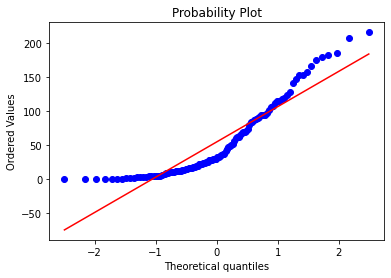

In [233]:
# observe distribution within the groups (qq plot histogram)
#check whether the data is normally distributed 
stats.probplot(df_cat['mean_cases_hdr_ths'], dist="norm", plot=pylab)
pylab.show()

In [234]:
# make historgram from datapoints
hist, edges = np.histogram(df_cat.mean_cases_hdr_ths, density = True, bins = 15)
p9 = figure(title = 'Mean case number distribution with overlayed estimated normal distribution',
           x_axis_label = 'mean cases per 100.000 inhabitants',
           y_axis_label = 'frequency',
           plot_height = 500,
           plot_width = 800)

p9.quad(top = hist, bottom = 0, left = edges[:-1], right = edges[1:], line_color="white")

#Add a vertical line at the position of the average. 
average = Span(location = np.mean(df_cat.mean_cases_hdr_ths),
                              dimension='height', line_color='red',
                              line_dash='dashed', line_width=3)
p9.add_layout(average)

#Add the normal distribution line to the plot. 
x = np.linspace(min(df_cat.mean_cases_hdr_ths), max(df_cat.mean_cases_hdr_ths), 101)

n = len(df_cat.mean_cases_hdr_ths)

# ML normal distribution:
mu_ML = np.mean(df_cat.mean_cases_hdr_ths)

# estimate sigma**2 with maximum likelihood method
sigma2_ML = np.mean((df_cat.mean_cases_hdr_ths - mu_ML)**2)

# calucalte sigma 
sigma_ML = np.sqrt(sigma2_ML)

# get sample variance
s2 = n/(n-1) * sigma2_ML

# get sample sd
s = np.sqrt(s2)

f_N_ML = np.array([stats.norm.pdf(xi, mu_ML, s) for xi in x])

p9.line(x = x, y = f_N_ML, line_color = 'red')
show(p9)

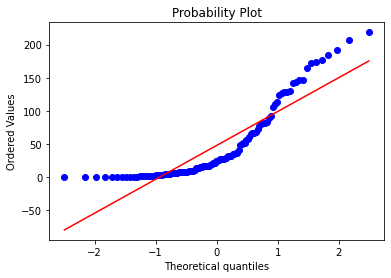

In [235]:
#check whether the data is normally distributed 
stats.probplot(df_cat['median_cases_hdr_ths'], dist="norm", plot=pylab)
pylab.show()

In [236]:
# make historgram from datapoints
hist, edges = np.histogram(df_cat.median_cases_hdr_ths, density=True, bins=15)
p10 = figure(title = 'Median case number distribution with overlayed estimated normal distribution',
           x_axis_label = 'median cases per 100.000 inhabitants',
           y_axis_label = 'frequency',
            plot_height = 500,
            plot_width = 800)

p10.quad(top = hist, bottom = 0, left = edges[:-1], right = edges[1:], line_color = "white")

#Add a vertical line at the position of the average. 
average = Span(location = np.mean(df_cat.median_cases_hdr_ths),
                              dimension='height', line_color='red',
                              line_dash='dashed', line_width=3)
p10.add_layout(average)

#Add the normal distribution line to the plot. 
x = np.linspace(min(df_cat.median_cases_hdr_ths), max(df_cat.median_cases_hdr_ths), 101)

n = len(df_cat.median_cases_hdr_ths)
# ML normal distribution:
mu_ML = np.mean(df_cat.median_cases_hdr_ths)
# estimate sigma**2 with maximum likelihood method
sigma2_ML = np.mean((df_cat.median_cases_hdr_ths - mu_ML)**2)

# calucalte sigma 
sigma_ML = np.sqrt(sigma2_ML)

# get sample variance
s2 = n/(n-1) * sigma2_ML

# get sample sd
s = np.sqrt(s2)

f_N_ML = np.array([stats.norm.pdf(xi, mu_ML, s) for xi in x])

p10.line(x = x, y = f_N_ML, line_color = 'red')

show(p10)

### Check for homogeneity of variance

Even without normality some sorts of parametric tests can be conducted if homogene variance is given. The homogeneity of variance will be assessed creating boxplots and conducting levene test. Levene's test was preferred over Bartletts test due to the not normal distributed data.

In [237]:
# boxplot showing the sleeping hours, categories for breakfast and no breakfast
p11 = df_cat.hvplot.box(y = 'median_cases_hdr_ths', 
                        by = 'dem_dim', 
                        color = 'dem_dim', 
                        cmap = Category20[5], 
                        legend = False,
                       title = 'Median case number distribution',
                       xlabel = 'population density category',
                       ylabel = 'median case number per 100.000 inhabitants').opts(frame_height = 500,
                                            frame_width = 500)

p11

:BoxWhisker   [dem_dim]   (median_cases_hdr_ths)

In [238]:
# levene test to check for variance homogenity
stats.levene(df_cat[df_cat.dem_dim == 'sparse']['median_cases_hdr_ths'], df_cat[df_cat.dem_dim == 'rural']['median_cases_hdr_ths'], 
             df_cat[df_cat.dem_dim == 'subrural']['median_cases_hdr_ths'], df_cat[df_cat.dem_dim == 'suburban']['median_cases_hdr_ths'],
            df_cat[df_cat.dem_dim == 'urban']['median_cases_hdr_ths'])


LeveneResult(statistic=0.9591206787229739, pvalue=0.43322837533770797)

In [239]:
# boxplot showing the sleeping hours, categories for breakfast and no breakfast
p12 = df_cat.hvplot.box(y = 'mean_cases_hdr_ths', 
                        by = 'dem_dim', 
                        color = 'dem_dim', 
                        cmap = Category20[5], 
                        legend = False,
                       title = 'Mean case number distribution',
                       xlabel = 'population density category',
                       ylabel = 'mean case number per 100.000 inhabitants').opts(frame_height = 500,
                                            frame_width = 500)

p12

:BoxWhisker   [dem_dim]   (mean_cases_hdr_ths)

In [240]:
# levenes test to check for variance homogenity
stats.levene(df_cat[df_cat.dem_dim == 'sparse']['mean_cases_hdr_ths'], df_cat[df_cat.dem_dim == 'rural']['mean_cases_hdr_ths'], 
             df_cat[df_cat.dem_dim == 'subrural']['mean_cases_hdr_ths'], df_cat[df_cat.dem_dim == 'suburban']['mean_cases_hdr_ths'],
            df_cat[df_cat.dem_dim == 'urban']['mean_cases_hdr_ths'])

LeveneResult(statistic=0.6490936447128045, pvalue=0.6287631971813206)

The data is not normally distributed. This can be seen in the line plot showing mean and median cases per 100.000 inhabitatns as well as in the qq plots and the histograms with overlayed theoretical normal distribution. The line plots indicate another distribution than normal because mean and median are differing. The qq plot shows strong deviation at the tails and a bit in the middle. The histograms show a skew to the left. 

The variances compared using a boxplot show, that the spread of the data seems to be comparable. The box sizes and locations are comparable. The whiskers do vary but not too much. The levene test results in p value clearly above 0.05 which leads to accepting the null hypothesis aiming for equal variances.

From not normal distributed data intuitively a non parametric test would be chosen (e.g. Mann-Whitnes-U-test) however when the variances are equal, an ANOVA is fine to be applied.

### One way ANOVA

In [241]:
# conducting an one way ANOVA
model = ols('median_cases_hdr_ths ~ dem_dim', data = df_cat).fit()
test_stat_median = sm.stats.anova_lm(model, typ=2)
test_stat_median

,sum_sq,df,F,PR(>F)
dem_dim,9048.569448,4.0,0.71113,0.586113
Residual,334010.612533,105.0,NaN,NaN


In [242]:
model = ols('mean_cases_hdr_ths ~ dem_dim', data = df_cat).fit()
test_stat_mean = sm.stats.anova_lm(model, typ=2)
test_stat_mean

,sum_sq,df,F,PR(>F)
dem_dim,4509.251906,4.0,0.362315,0.834937
Residual,326699.128187,105.0,NaN,NaN


The previously conducted ANOVA, aiming to confirm differences among the population did not result in significant p value (below 0.05) so the alternative hypothesis, a significant difference in case numbers, needs to be rejected. This is not really surprising bearing in mind the high regional variability which did not really show a clear trend per population density category. Hypothesis 2: There is a significant difference in spreading between rural and urban areas cannot be proofen.

# Analyse the virus variant cirucaltion per category (Hypothesis 2b)

Analyse whether there are shared trends of virus types among each category and whether there are differences among the sparse and dense populated districts.

In [243]:
# add the category column to the dataset
df_dis_vt['dem_dim'] = pd.cut(df_dis_vt['mean_pop_dens_exp'], bins=[0, 150, 300, 500, 1500, float('Inf')], 
                                       labels=['sparse', 'rural', 'subrural', 'suburban', 'urban'])

df_dis_vt.isnull().sum()

C:\Users\chiar\AppData\Local\Temp/ipykernel_12612/1347343014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dis_vt['dem_dim'] = pd.cut(df_dis_vt['mean_pop_dens_exp'], bins=[0, 150, 300, 500, 1500, float('Inf')],


district             0
virus_type           0
season               0
case_number          0
year                 0
pop_exp              0
pop_dens_exp         0
mean_pop_dens_exp    0
cases_hdr_ths        0
dem_dim              0
dtype: int64

In [244]:
df_dis_vt[(df_dis_vt.dem_dim == 'urban') & (df_dis_vt.year.isin(yl))]

,district,virus_type,season,case_number,year,pop_exp,pop_dens_exp,mean_pop_dens_exp,cases_hdr_ths,dem_dim
171,KAS,IF A,2000/01,19.0,2000,270479.21,1559.41,1694.403636,7.024569,urban
172,KAS,IF A(H1N1) pandemic09,2000/01,0.0,2000,270479.21,1559.41,1694.403636,0.000000,urban
173,KAS,IF A(H1N1) prepandemic,2000/01,0.0,2000,270479.21,1559.41,1694.403636,0.000000,urban
174,KAS,IF A(H1N2),2000/01,0.0,2000,270479.21,1559.41,1694.403636,0.000000,urban
175,KAS,IF A(H3N2),2000/01,0.0,2000,270479.21,1559.41,1694.403636,0.000000,urban
176,KAS,IF A/B not determined,2000/01,0.0,2000,270479.21,1559.41,1694.403636,0.000000,urban
177,KAS,IF B,2000/01,1.0,2000,270479.21,1559.41,1694.403636,0.369714,urban
178,KAS,IF C,2000/01,0.0,2000,270479.21,1559.41,1694.403636,0.000000,urban
179,KAS,not determined,2000/01,0.0,2000,270479.21,1559.41,1694.403636,0.000000,urban
216,MA,IF A,2000/01,2.0,2000,268950.89,1855.35,2014.895000,0.743630,urban


In [245]:
# visualize the case numbers per virus variant (tabs) and selectable population density category
def district_cat_vt_plot(df = df_dis_vt, dem_dim = ['sparse']):
    """
    Creates a line plot showing the case number per 100.000 inhabitants per inlfuenza virus type
    for each district, orgnazied in population density categories.
    
    :parameters
    -----------
    dem_dim - list
        population density category Defaults to `['sparse']`
    df- pd.DataFrame
        Data frame to get data from. Defaults to `df_dis_vt`
        
    :returns
    --------
    tabs - tabbed figure
        line plot
    """
    #make data selection based on dropdown or checkbox: options are sparse, rural, subrural, suburban, urban
    df_dem_dim_vt = df_dis_vt[df_dis_vt.dem_dim == dem_dim]
    
    # filter the data by virus type and use this to generate virus type tabs
    for it, vt_group in enumerate(df_dem_dim_vt.virus_type.unique()):
        data = df_dem_dim_vt[df_dem_dim_vt.virus_type == vt_group]
        
        p = figure(title = '4b) Case numbers per 100.000 inhabitants per virus type and population district',
                  x_axis_label = 'years',
                  y_axis_label = 'case number per 100.000 inhabitants',
                  plot_height = 500,
                  plot_width = 800,
                  tools = 'hover',
                  tooltips = '@year: @cases_hdr_ths for @district')
        
        for district, color in zip(data.district.unique(), line_col):
            dfs = data[data.district == district]
            cds = ColumnDataSource(data = dfs)
            p.line(x = 'year', y = 'cases_hdr_ths', line_width = 2, line_color = color, legend_label = district, source = cds)
        
        # define legend
        legend = p.legend[0]

        # arrange legend
        p.center = [item for item in p.center if not isinstance(item, Legend)]

        # place legend
        p.add_layout(legend, 'right')

        tab = Panel(child = p, title = '{}'.format(vt_group))
        if it == 0:
            tabs_list = [tab]
            tabs = Tabs(tabs=tabs_list)

        # append the other plots as tabs
        else:
            tabs_list.append(tab)
            tabs.update(tabs=tabs_list)

    tabs = Tabs(tabs = tabs_list)
    
    return tabs

# population denisty category selecter
area_select = pn.widgets.Select(name = 'districts by population density', options = ['sparse', 'rural', 'subrural', 'suburban', 'urban'])
area_select

# connect checkboxes and tabbed plot
p13 = pn.interact(district_cat_vt_plot, dem_dim = area_select)
p13

Column(sizing_mode='stretch_width')
    [0] Column(sizing_mode='stretch_width')
        [0] Select(name='districts by p..., options=['sparse', 'rural', ...], sizing_mode='stretch_width', value='sparse')
    [1] Row(sizing_mode='stretch_width')
        [0] Bokeh(Tabs, name='interactive09089', sizing_mode='stretch_width')

As already seen for whole Baden - Württemberg, the virus variants do contribute to differing extent to the case numbers. Their appearance over time differs. Per population density category strong variation is seen. However to get an impression about when variants were observed in which category the case numbers per virus type category are averaged and viusalized.

In [246]:
# get summary values (min, mean, max case numbers)
df_dis_vt_sum = df_dis_vt.groupby(['dem_dim', 'virus_type', 'year']).agg({'cases_hdr_ths': ['min', 'mean', 'max']}).reset_index()
df_dis_vt_sum.columns = ['dem_dim', 'virus_type', 'year', 'min_cases_hdr_ths', 'mean_cases_hdr_ths', 'max_cases_hdr_ths']
df_dis_vt_sum

,dem_dim,virus_type,year,min_cases_hdr_ths,mean_cases_hdr_ths,max_cases_hdr_ths
0,sparse,IF A,2000,0.000000,6.757025,16.436435
1,sparse,IF A,2001,0.000000,4.214005,19.084589
2,sparse,IF A,2002,0.000000,0.569980,1.953643
3,sparse,IF A,2003,0.000000,7.604740,30.649998
4,sparse,IF A,2004,0.000000,8.689341,44.338182
...,...,...,...,...,...,...
985,urban,not determined,2017,0.324265,9.079752,26.436321
986,urban,not determined,2018,0.000000,9.178770,27.219761
987,urban,not determined,2019,0.000000,1.592599,3.835712
988,urban,not determined,2020,0.000000,0.000000,0.000000


In [247]:
# visualize the average trend for each population density category
for it, vt_group in enumerate(df_dis_vt_sum.virus_type.unique()):
    data = df_dis_vt_sum[df_dis_vt_sum.virus_type == vt_group]
    
    #define figure canvas
    p = figure(title = '3b) Case number per 100.000 inhabitants per virus type averaged per population density category',
              x_axis_label = 'years',
              y_axis_label = 'case number per 100.000 inhabitants',
              plot_height = 500,
              plot_width = 800,
              tools = 'hover',
              tooltips = '@year: @mean_cases_hdr_ths for @dem_dim')
    
    # draw multiple lines
    for category, color in zip(data.dem_dim.unique(), line_col):
        dfs = data[data.dem_dim == category]
        cds = ColumnDataSource(dfs)
        p.line(x = 'year', y = 'mean_cases_hdr_ths', line_width = 2, line_color = color, legend_label = category, source = cds)
    
    # define legend
    legend = p.legend[0]

    # arrange legend
    p.center = [item for item in p.center if not isinstance(item, Legend)]

    # place legend
    p.add_layout(legend, 'right')

    tab = Panel(child = p, title = '{}'.format(vt_group))
    if it == 0:
        tabs_list = [tab]
        tabs = Tabs(tabs=tabs_list)

    # append the other plots as tabs
    else:
        tabs_list.append(tab)
        tabs.update(tabs=tabs_list)

p14 = Tabs(tabs = tabs_list)

show(p14)

The average case numbers for Influenza A follows a common trend for all population density categories. Since influenza A contributes the most to the case numbes (it is the most prevalent virus type) it seems reasonable that from the data available in this study no significant differences can be observed between the population density categories. The influenza A (H1N1) type was pandemic in year 2009 (equals season 2009/10), which is observed for all categories similarly. The subtype family was introduced in the year 2004. the particular variant which led to the 2009 pandemic is better known as the pathogen of swine flu. The A (H1N1) subfamily leads to prepandemic and pandemic on regular basis. Well known for example is the spanish flu. It is not surprising that there are a lot of fluctutations seen, which differ quite a lot between the population density categories.  Influenza A subtype (H1N2) started to circulate in 2012. Influenza A (H3N2) is circulating since start of recordings in all categories.

Observing cases were not laboratory diferentiation between influenza A and B was conducted, increasing numbers aare observed from 2010 onwards, except for the urban category. A wild guess for reasoning might be, that in urban areas the laboratory capacity is higher, which allows to conduct differentiation for each sample.

Influenza B cases were increasing from start of recording towrds the year 2017 from then onwards strong decrease is seen.

Influenza C is in general not that much ciruclating in Baden - Württemberg, however in the rural areas it was observed to a small extent in 2008.

A statistical analysis on the differences between the representation of virus variants among the categories is not conducted, because the visualization already indicates that there are not clear differences among the categories. If shared patterns and differences would be present a two way ANOVA with the categories population density category and virus type could be conducted. Hypothesis 2b, that per population density category equal patterns of virus type circulation and differing patterns among the categories are present seems unlikely from the previous two visualisations.

From the analysis conducted so far, it can be concluded, that seasonal influenza became more prevalent from start of recording until 2017. The decrease happened afterwards can partly be explained by the COVID pandemic starting in february 2020 but there must have been other reasons as well. Further, the population density does not seem to be the crucial parameter for spreading and accordingly case numbers. The patterns are probably more complex and further insight cannot be derived without additional data about the reagion and the patients. Lastly, there were some differences seen in when virus types arose the first time, which will be studied in the last part of this study. Limitations will arise because variant determination is has not been conducted to the extent we are used to from the COVID-pandemic. 

# Study the influenza strain diversity increase

Seasonal influenza is mainly caused by the influenza types A, B, C and D. In Baden - Württemberg influenza A with subtypes and influenza B is prevalent. Influenza C was observed to a very small extent. Influenza A has several subtypes from which the most important ones are determined in the lab. They can be classified by their combination of hemagglutinin and neuraminidase proteins on their surface. [https://www.who.int/news-room/fact-sheets/detail/influenza-(seasonal)] The pathogens of spanish flu and swine flu belong to this influenza virus type. Keeping this information in mind Influenza A subtypes are  likely to result into pandemics. Influenza B viruses do not have subtypes but two lineages are distinguished: namely B/Yamagata and B/Victoria. In this dataset a sepration of the two lineages is not provided. For influenza C nothing is known about subtypes or lineages since it causes only mild symptoms and is therefore less reported and studied. [https://www.who.int/news-room/fact-sheets/detail/influenza-(seasonal)]

In [248]:
# study it for whole Baden - Württemberg
# make a boolean variable indicating whether a virus type was present or not in a year
df_bw_vt['virus_type_bool'] = df_bw_vt.case_number > 0
df_bw_vt['virus_type_bool'] = df_bw_vt.virus_type_bool.astype(int)

In [249]:
# transform dataset into wide format
df_bw_vt = df_bw_vt[['year', 'virus_type', 'virus_type_bool']]

df_bw_vt_wide = df_bw_vt.pivot_table(values = 'virus_type_bool', index = ['virus_type'], columns = 'year')
df_bw_vt_wide

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
virus_type,,,,,,,,,,,,,,,,,,,,,
IF A,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
IF A(H1N1) pandemic09,0,0,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
IF A(H1N1) prepandemic,0,0,0,1,1,1,1,1,1,0,...,0,1,1,1,1,1,1,1,1,0
IF A(H1N2),0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,0,0
IF A(H3N2),0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
IF A/B not determined,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
IF B,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
IF C,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
not determined,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [250]:
# visualize presensce (1) and absence (0) of each virus type for BW as a whole
p15 = df_bw_vt_wide.hvplot.heatmap(
    x = 'columns', 
    y = 'index',
    title = '2a) Presence/absence of virus types in Baden - Württemberg', 
    cmap = ['#1a9641', '#d7191c'], 
    xaxis = 'top',
    rot=70).opts(
    frame_width = 400, frame_height = 400, colorbar = True, axiswise = True,
    toolbar = None,
    fontsize={'title': 10, 'xticks': 8, 'yticks': 8})

p15

:HeatMap   [columns,index]   (value)

The main types of influenza (A and B) are present from beginning of recording. However influenza C was only found in one year of the recordings. Important influenza subtypes did arose later in time and sometimes disappeared again.

In [251]:
# sum up the number of ciruclating virus variants per year for a calender heatmap
df_bw_vt_sum = df_bw_vt.groupby('year').sum().reset_index()
df_bw_vt_sum['vt'] = 'Baden Württemberg'
df_bw_vt_sum.columns = ['year', 'nr_present_vt', 'vt']
df_bw_vt_sum
df_bw_vt_sum_wide = df_bw_vt_sum.pivot_table(values = 'nr_present_vt', index = ['vt'], columns = 'year')
df_bw_vt_sum_wide

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
vt,,,,,,,,,,,,,,,,,,,,,
Baden Württemberg,3,5,5,6,7,7,7,7,8,6,...,6,8,8,8,8,8,8,8,6,4


In [252]:
# viualise the number of circulating virus variants for whole BW
p16 = df_bw_vt_sum_wide.hvplot.heatmap(
    x = 'columns', 
    y = 'index', 
    title = '2b) Number of circulating virus types in Baden - Württemberg', 
    cmap=['#1a9850', '#91cf60', '#d9ef8b', '#ffffbf', '#fee08b', '#fc8d59', '#d73027'], 
    xaxis='top', 
    rot=70).opts(
    frame_width = 400, frame_height = 400, colorbar=True, axiswise=True,
    toolbar=None, 
    fontsize={'title': 10, 'xticks': 8, 'yticks': 8})

p16

:HeatMap   [columns,index]   (value)

The virus variant circulation studied for whole Baden - Württemberg has indeed increased over the years and declined from 2020 onwards again. However a strong increase from 2012 onwards cannot be seen. This does not mean that it could not be there it is just not captured by the provided data (e.g. B lineageas are not seprately recorded)

In [253]:
# transform dataframe with districts into wide dataframe which summarised the districts to the population density categories
df_dis_vt_sum['virus_type_bool'] = df_dis_vt_sum.mean_cases_hdr_ths > 0
df_dis_vt_sum['virus_type_bool'] = df_dis_vt_sum.virus_type_bool.astype(int)
df_cat_vt_sum = df_dis_vt_sum[['dem_dim', 'year', 'virus_type', 'virus_type_bool']].groupby(['dem_dim', 'year']).sum().reset_index()
df_cat_vt_sum_wide = df_cat_vt_sum.pivot_table(values = 'virus_type_bool', index = ['dem_dim'], columns = 'year')

In [254]:
df_cat_vt_sum_wide

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
dem_dim,,,,,,,,,,,,,,,,,,,,,
sparse,3,4,3,3,5,5,4,6,7,6,...,6,6,7,8,6,7,7,8,3,1
rural,3,5,4,4,6,6,6,7,8,6,...,6,7,6,7,8,7,7,7,4,4
subrural,3,4,4,6,5,7,7,7,6,5,...,6,6,7,7,8,8,8,7,4,1
suburban,2,4,5,5,6,5,6,7,7,4,...,6,7,7,7,7,7,7,8,2,3
urban,3,4,4,4,6,5,6,5,5,5,...,5,6,6,6,7,7,7,7,3,2


In [255]:
#visualise number of ciruclating virus types per category and year
p17 = df_cat_vt_sum_wide.hvplot.heatmap(
    x = 'columns', 
    y = 'index', 
    title = '3d) Number of circulating virus types in per population density category', 
    cmap=['#1a9850', '#66bd63', '#a6d96a', '#d9ef8b', '#fee08b', '#fdae61', '#f46d43', '#d73027'], 
    xaxis='top', 
    rot=70).opts(
    frame_width = 400, frame_height = 400, colorbar = True, axiswise = True,
    toolbar=None, 
    fontsize={'title': 10, 'xticks': 8, 'yticks': 8})

p17

:HeatMap   [columns,index]   (value)

The number of ciruclation is slightly differing among the categories. Shared trend is, that the two COVID-pandemic years are presenting with lower number of circulating virus types. Te cirulation is steadily above 5 types from 2012 onwards until 2019.

In [256]:
# transform district and virus type dataset into its wide form
df_dis_vt_sub = df_dis_vt[['district', 'virus_type', 'year', 'case_number']]
df_dis_vt_sub['virus_type_bool'] = df_dis_vt_sub.case_number > 0
df_dis_vt_sub['virus_type_bool'] = df_dis_vt_sub.virus_type_bool.astype(int)
df_dis_vt_sub = df_dis_vt_sub.groupby(['district', 'year']).sum().reset_index()
df_dis_vt_sub_wide = df_dis_vt_sub.pivot_table(values = 'virus_type_bool', index = ['district'], columns = 'year')

C:\Users\chiar\AppData\Local\Temp/ipykernel_12612/2955194228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dis_vt_sub['virus_type_bool'] = df_dis_vt_sub.case_number > 0
C:\Users\chiar\AppData\Local\Temp/ipykernel_12612/2955194228.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dis_vt_sub['virus_type_bool'] = df_dis_vt_sub.virus_type_bool.astype(int)


In [257]:
# visualise number of circulating virus types per district and year
p18 = df_dis_vt_sub_wide.hvplot.heatmap(
    x = 'columns', 
    y = 'index', 
    title = '4c) Number of circulating virus types per district', 
    cmap=['#1a9850', '#66bd63', '#a6d96a', '#d9ef8b', '#ffffbf', '#fee08b', '#fdae61', '#f46d43', '#d73027'], 
    xaxis='top', 
    rot=70).opts(
    frame_width = 400, frame_height = 400, colorbar=True, axiswise=True,
    toolbar=None, 
    fontsize={'title': 10, 'xticks': 8, 'yticks': 8})

p18

:HeatMap   [columns,index]   (value)

The number of circulating virus types is following similar trends for all the districts with some exceptions especially for no virus type circulation from 2017 onwards. This seems to be unlikely it is more likely that no recording was performed in these years. But generally in the beginning of the recording less types were observed increase was seen from 2012 onwards, and sudden decrease in 2020 and 2021.

# Visualize the case numbers per district

To plot analyse the case number increase next to the strain diversity a geographical representation will be created. 

In [258]:
# read geojson file
import json
communities_geo = r'C:/Data_Science_for_Life_Sciences_MASTER/programming1/programming_1_influenza/data/geodata/landkreise_simplify200.geojson'

# open the json file - json.load() methods returns a python dictionary
with open(communities_geo, 'rb') as communities_file:
    communities_json = json.load(communities_file)


# loop through feature property of geojson file to obtain the district names in order of the geojson file
for index in range(len(communities_json['features'])):
    print(communities_json['features'][index]['properties']['GEN'])

Stuttgart
Boeblingen
Esslingen
Goeppingen
Ludwigsburg
Rems-Murr-Kreis
Heilbronn
Heilbronn
Hohenlohekreis
Schwaebisch Hall
Main-Tauber-Kreis
Heidenheim
Ostalbkreis
Baden-Baden
Karlsruhe
Karlsruhe
Rastatt
Heidelberg
Mannheim
Neckar-Odenwald-Kreis
Rhein-Neckar-Kreis
Pforzheim
Calw
Enzkreis
Freudenstadt
Freiburg im Breisgau
Breisgau-Hochschwarzwald
Emmendingen
Ortenaukreis
Rottweil
Schwarzwald-Baar-Kreis
Tuttlingen
Konstanz
Loerrach
Waldshut
Tuebingen
Zollernalbkreis
Ulm
Alb-Donau-Kreis
Biberach
Bodenseekreis
Ravensburg
Sigmaringen
Konstanz


In [259]:
# prepare the dataframe with case numbers for the geomap
# filter the dataset
df_dis_tl = df[['district', 'virus_type', 'season', 'case_number', 'year', 'pop_exp', 'pop_dens_exp', 'mean_pop_dens_exp']]

# aggregate it to get total case numbers
df_dis_tl = df_dis_tl.groupby(['district', 'year']).agg({'case_number': ['sum'], 'pop_exp': ['mean'], 'pop_dens_exp': ['mean'], 'mean_pop_dens_exp': ['mean']}).reset_index()

#rename colums
df_dis_tl.columns = ['district', 'year', 'case_number', 'pop_exp', 'pop_dens_exp', 'mean_pop_dens_exp']

# calculate case numbers per 100.000 inhabitants
df_dis_tl['cases_hdr_ths'] = (df_dis_tl['case_number'] / df_dis_tl['pop_exp']) * 100000

# get population density categories
df_dis_tl['dem_dim'] = pd.cut(df_dis_tl['mean_pop_dens_exp'], bins=[0, 150, 300, 500, 1500, float('Inf')], 
                                       labels=['sparse', 'rural', 'subrural', 'suburban', 'urban'])

df_dis_tl.head()

,district,year,case_number,pop_exp,pop_dens_exp,mean_pop_dens_exp,cases_hdr_ths,dem_dim
0,AD,2000,20.0,170214.78,125.35,136.314545,11.749861,sparse
1,AD,2001,14.0,171632.96,126.39,136.314545,8.156941,sparse
2,AD,2002,34.0,173051.15,127.44,136.314545,19.647370,sparse
3,AD,2003,7.0,174469.33,128.48,136.314545,4.012166,sparse
4,AD,2004,18.0,175887.51,129.53,136.314545,10.233814,sparse


In [260]:
# prepare dataset which holds cases per virus type for geomap
# get cases per 100.000
df['cases_hdr_ths'] = (df['case_number'] / df['pop_exp']) * 100000

#filter
df_dis = df[['district', 'year', 'virus_type', 'cases_hdr_ths', 'mean_pop_dens_exp']]

#get categories
df_dis['dem_dim'] = pd.cut(df_dis['mean_pop_dens_exp'], bins=[0, 150, 300, 500, 1500, float('Inf')], 
                                       labels=['sparse', 'rural', 'subrural', 'suburban', 'urban'])
df_dis.head()

C:\Users\chiar\AppData\Local\Temp/ipykernel_12612/1228664745.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dis['dem_dim'] = pd.cut(df_dis['mean_pop_dens_exp'], bins=[0, 150, 300, 500, 1500, float('Inf')],


,district,year,virus_type,cases_hdr_ths,mean_pop_dens_exp,dem_dim
0,AD,2000,IF A,11.749861,136.314545,sparse
1,AD,2000,IF A(H1N1) pandemic09,0.000000,136.314545,sparse
2,AD,2000,IF A(H1N1) prepandemic,0.000000,136.314545,sparse
3,AD,2000,IF A(H1N2),0.000000,136.314545,sparse
4,AD,2000,IF A(H3N2),0.000000,136.314545,sparse


In [261]:
# transform the total case number dataset into wide format
df_dis_tl_wide = df_dis_tl.pivot_table(values = 'cases_hdr_ths', index = ['district', 'dem_dim'], columns = 'year').reset_index()
df_dis_tl_wide.head()

year,district,dem_dim,2000,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AD,sparse,11.749861,8.156941,19.647370,4.012166,10.233814,6.767972,10.071402,12.212584,...,48.602554,5.300789,107.855381,34.989227,82.942084,27.788660,168.589222,242.949593,2.517897,0.000000
1,BAD,subrural,2.067389,2.051898,4.073274,2.021602,8.027146,11.953122,174.046261,37.308707,...,13.269549,79.069912,132.753134,193.136558,206.592172,0.000000,0.000000,0.000000,0.000000,0.000000
2,BB,suburban,0.614541,14.588219,27.959890,14.574396,50.030497,5.824460,35.450143,43.930606,...,70.558910,8.869224,67.614361,39.288426,97.431454,245.328942,140.510417,201.476966,2.265975,3.243782
3,BC,sparse,7.244110,2.984711,5.313213,7.006986,6.353744,1.142891,33.359063,11.189932,...,4.785321,2.105886,4.170742,2.065252,1.022758,4.052311,157.060053,365.886202,0.000000,0.000000
4,BHS,rural,1.802937,0.892390,15.461107,10.497235,10.394615,0.857832,24.213785,17.672286,...,120.106344,11.146354,176.753477,33.630860,180.250248,570.260734,269.344630,303.309415,0.749054,1.114163


In [262]:
# transform the case number per influenza type dataset into wide format
df_dis_wide = df_dis.pivot_table(values = 'cases_hdr_ths', index = ['district', 'virus_type', 'dem_dim'], columns = 'year').reset_index()
df_dis_wide.head()

year,district,virus_type,dem_dim,2000,2001,2002,2003,2004,2005,2006,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AD,IF A,sparse,11.749861,3.495832,0.0,1.146333,1.705636,5.639977,6.154746,...,17.091008,2.120316,61.030362,15.144591,44.062982,1.029210,161.436952,181.578192,1.510738,0.0
1,AD,IF A(H1N1) pandemic09,sparse,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,4.272752,0.530079,5.261238,0.522227,0.518388,4.116839,2.554382,4.564815,0.000000,0.0
2,AD,IF A(H1N1) prepandemic,sparse,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,AD,IF A(H1N2),sparse,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,AD,IF A(H3N2),sparse,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.534094,1.590237,1.578371,0.000000,4.665492,0.000000,2.043506,0.000000,0.000000,0.0


In [263]:
# names in the data frame
dataframe_names = df_dis_wide.district.unique().tolist()
dataframe_names
# names in the json file - the same order as in the data frame 
geojson_names = ['Alb-Donau-Kreis', 'Baden-Baden', 'Boeblingen', 'Biberach', 'Breisgau-Hochschwarzwald', 'Zollernalbkreis', 
                 'Bodenseekreis',   'Calw', 'Emmendingen', 'Enzkreis', 'Esslingen', 'Freudenstadt', 'Freiburg im Breisgau',
                 'Goeppingen', 'Heidelberg', 'Heidenheim', 'Heilbronn', 'Heilbronn',  'Karlsruhe',  'Karlsruhe', 'Konstanz',
                 'Hohenlohekreis', 'Loerrach', 'Ludwigsburg', 'Mannheim', 'Main-Tauber-Kreis', 'Neckar-Odenwald-Kreis',
                 'Ostalbkreis', 'Ortenaukreis', 'Pforzheim', 'Rastatt', 'Rems-Murr-Kreis', 'Rhein-Neckar-Kreis',
                 'Ravensburg', 'Rottweil', 'Stuttgart', 'Schwaebisch Hall', 'Sigmaringen', 'Tuebingen', 'Tuttlingen',
                 'Ulm', 'Schwarzwald-Baar-Kreis', 'Waldshut']

# replace data frame names by json names
df_dis_wide.replace(dict(zip(dataframe_names, geojson_names)), inplace=True)
dataframe_names
df_dis_wide.district

# get dataframe names for the dataset with total case numbers
dataframe_names1 = df_dis_tl_wide.district.unique().tolist()
df_dis_tl_wide.replace(dict(zip(dataframe_names1, geojson_names)), inplace = True)
df_dis_tl_wide.district

0              Alb-Donau-Kreis
1                  Baden-Baden
2                   Boeblingen
3                     Biberach
4     Breisgau-Hochschwarzwald
5              Zollernalbkreis
6                Bodenseekreis
7                         Calw
8                  Emmendingen
9                     Enzkreis
10                   Esslingen
11                Freudenstadt
12        Freiburg im Breisgau
13                  Goeppingen
14                  Heidelberg
15                  Heidenheim
16                   Heilbronn
17                   Heilbronn
18                   Karlsruhe
19                   Karlsruhe
20                    Konstanz
21              Hohenlohekreis
22                    Loerrach
23                 Ludwigsburg
24                    Mannheim
25           Main-Tauber-Kreis
26       Neckar-Odenwald-Kreis
27                 Ostalbkreis
28                Ortenaukreis
29                   Pforzheim
30                     Rastatt
31             Rems-Murr-Kreis
32      

In [264]:
# make year dropdown selector
year_select = pn.widgets.Select(name = 'Year', options = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,2016,2017,2018,2019,2020,2021])

# make population density dropdown selector
area_select = pn.widgets.Select(name = 'districts by population density', options = ['all','sparse', 'rural', 'subrural', 'suburban', 'urban'])

# make virus type dropdown selector
virus_select = pn.widgets.Select(name = 'virus type', options = ['all', 'IF A', 'IF A(H1N1) pandemic09', 'IF A(H1N1) prepandemic',
       'IF A(H1N2)', 'IF A(H3N2)', 'IF A/B not determined', 'IF B',
       'IF C', 'not determined'])


# decorate plot function with the depending selectors
@pn.depends(year = year_select, virus_type = virus_select, area = area_select)
def geomap_plot(year: list = [2000], virus_type: list = 'all', area: list = 'all', df1 = df_dis_tl_wide, df2 = df_dis_wide) -> figure:
    """
    Creates a geographical representation on district level for total case numbers and case numbers per virus type
    
    :parameters
    -----------
    year - list
        year of interest. Defaults to `[2000]`
    virus_type - list
        virus type to choose. Defaults to `['all']`
    area - list
        areas with similar population density. Defaults to `['all']`
    df1 - pd.DataFrame
        Data frame to get data from for the total case numbers. Defaults to `df_dis_tl_wide`
    df2 - pd.DataFrame
        Data frame to get data from for the case numbers per virus type. Defaults to `df_dis_wide`
        
    :returns
    --------
    folium_pane - figure
        geomap plot
        
    :depends
    --------
    year_select - Select
        Widget to select for which year case numbers are shown
    area_selcet - Select
        Widget to select for which districts case numbers are shown
    virus_select - Select
        Widget to select for which virus type case numbers are shown 
    """
    
    # select the dataset and subset it based on virus type
    if virus_type == 'all':
        df = df1
    else:
        df = df2[df2.virus_type == virus_type]
    
    # select the relevant areas from dataset
    if area != 'all':
        df = df[df.dem_dim == area]
    
    districts_geo = r'C:/Data_Science_for_Life_Sciences_MASTER/programming1/programming_1_influenza/data/geodata/landkreise_simplify200.geojson'

    # create a plain world map
    communities_map = folium.Map(location = [48.758339, 8.843008], zoom_start = 7.5, tiles = 'OpenStreetMap')
    
    # generate choropleth map 
    choropleth = folium.Choropleth(#communities_map.choropleth(
        geo_data=districts_geo,
        data=df,
        columns=['district', year],
        key_on='feature.properties.GEN',
        fill_color='OrRd',
        fill_opacity=1, 
        line_opacity=1,
        legend_name='cases per 100.000 inhabitants',
        smooth_factor=0).add_to(communities_map)
    
    # add labels indicating the name of the community
    style_function = "font-size: 15px; font-weight: bold"
    choropleth.geojson.add_child(
        folium.features.GeoJsonTooltip(['GEN'], style=style_function, labels=False))

    # create a layer control
    folium.LayerControl().add_to(communities_map)
    
    folium_pane = pn.pane.plot.Folium(communities_map, height = 800, width = 800)
        
    return pn.Row(folium_pane)

geomap_layout = pn.Column(pn.pane.Markdown("######**4a) Geographical representation**"),
                        pn.Column(year_select, area_select, virus_select),
                        geomap_plot)
geomap_layout

Column(sizing_mode='stretch_width')
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] Column(sizing_mode='stretch_width')
        [0] Select(name='Year', options=[2000, 2001, 2002, ...], sizing_mode='stretch_width', value=2000)
        [1] Select(name='districts by p..., options=['all', 'sparse', ...], sizing_mode='stretch_width', value='all')
        [2] Select(name='virus type', options=['all', 'IF A', ...], sizing_mode='stretch_width', value='all')
    [2] ParamFunction(function, sizing_mode='stretch_width')

# Built the dashboard

In [265]:
# text for dashboard

abstract = pn.pane.Markdown("""
# Developement of influenza cases in Baden - Württemberg
Seasonal influenza is an infectious disease with increasing prevalence in Baden-Württemberg.
The prevalent types are influenza A, B and C. Influenza A comes with several subtypes classified
by their surface proteins hemagglutinin and neuraminidase. Influenza A subtypes are well known for
causing pandemics (e.g. spanish flu, swine flu). Influenza B is distinguished into two lineages: 
B/Yamagata and B/Victoria. Influenza C is not observed in high case numbers and symptoms are mild,
so extensive types/lineage analysis is not performed by the WHO. [1]

It was stated that the increase in prevalence was boosted from 2012 onwards due to a sudden
increase in strain diversity. Further the COVID restrictions from 2020 onwards were aimed to
prevent the expected influenza waves and might even have led to loss of some influenza strains. The
COVID measurement mainly reduced the close-coming-together of people. [2, 3]

This study aimed to dis/proof the following hypotheses:

1.) There is a constant increase in prevalence, which is steeper from 2012 onwards with sudden decrease
in 2020.

2a.) The spreading in sparse populated regions differs from the spreading in dense populated regions.

2b.) The pattern of arising of virus types is differing among the sparse and dense populated regions.

3.) An increase in virus type diversity contributes to higher case numbers.

------------
""", width = 500, margin = (25))

Header_BW = pn.pane.Markdown("""
# Analysing the case numbers in total and distinguished by virus types in Baden - Württemberg as a whole

------------
""", width = 500, margin = (25))

hypo1 = pn.pane.Markdown("""
## Hypothesis 1
In figure 1a) a monotone increase can be observed over time. The proposed drop of case numbers in 2020 is
clearly visible. To assess whether the increase from 2012 to 2019 was steeper than in the period
from 2000 to 2012, a linear curve fitting was conducted for the three time periods of interest: before
2012, 2012 - 2019, 2020/2021. The slopes of the linear polynoms are shown in the table above. Indeed,
the slope for middle time interval is the steepest.

In figure 1b) the contribution of virus types to the case numbers is shown. Influenza A seems to be the type
contributing the most and therefore determining the magnitude of case numbers. In year 2009 a single infuenza
a subtype caused a pandemic (which is the swine flu pathogen). From this representation it cannot be answered,
whether increasing strain diversity is happening from 2012 onwards.

------------
""", width=500, margin=(25))


hypo3_1 = pn.pane.Markdown("""
## Hypothesis 3: Level: whole Baden - Württemberg
The figures 2a) and 2b) show the presence / absence or the number of circulating virus types per year in
Baden - Württemberg. For the influenza A subtypes a later onset is seen as well as disappering after some years.
A constant increase in virus types is not seen, however from 2013 onwards constantly highest number of determined
virus types is circulating.

------------
""", width=500, margin=(25))


Header_cat = pn.pane.Markdown("""
# Analysing the case numbers in total and distinguished by virus types per districts grouped into categories by their population density

------------
""", width=500, margin=(25))


hypo_2a = pn.pane.Markdown("""
## Hypothesis 2a)
The districts of Baden - Württemberg were classified in 5 subcategories:

- sparse: population density < 150
- rural: population density < 300
- subrural: population density < 500
- suburban: population density < 1500
- urban: populationd density > 1500

The plots 3a) 3b) and 3c) as well as the table 2 show the differences in case numbers among the categories. Neither 
visually nor through statistical testing (one way ANOVA) are significant differences found. As well, a strong variation
within each category was found, which will be shown later on.

------------
""", width=500, margin=(25))


hypo_2b = pn.pane.Markdown("""
## Hypothesis 2b)
Plot 3d) visualizes the number of circulating virus types per category and year. Common trend is the sudden decrease of
virus types in 2020/2021.

------------
""", width=500, margin=(25))


Header_dis = pn.pane.Markdown("""
# Analysing the case numbers in total and distinguished by virus types per districts

------------
""", width=500, margin=(25))


hypo_3 = pn.pane.Markdown("""

## Hypothesis 3
Figure 4a) allows to investigate the case numbers per year and virus type. Note, the encoding of the case numbers adjusts to 
the values provided, be careful before drawing conculsions. The population density can be investigated, by
selecting all areas belonging to a category. The districts not belonging to that category are shown black. Figure 4b) shows
the case numbers per virus type on district level. For some virus types and category, shared patterns are seen for others
high variability is seen. From this it can be concluded, that population density is not the only parameter, distinguishing the
spreading and the number of circulating virus types. Dropping case numbers to 0 for quite some districts can be seen from the
year 2017 onwards, which is contrary to the general trend. It might be due to less strict recordings in these years. Figure
4c) shows the number of circulating virus types per district and year. Common patterns are few virus types in the beginning of
the recording and in the end. The early case number dropping seen in 4b is here refelcted as 0 virus types circulating from 2017
onwards for some districts. Commonly, the last 2 years are characterized by low number of circulating virus types, with one
exception.

To wrap up, seasonal influenza became more prevalent in the pre-COVID years. It might return when covid restriction will be
reduced, it is difficult to predict. There were no significant differences in spreading found among dense and sparse populated
areas. The virus type diversity tends to increase with coming to hold by the COVID measurements. The significance of the findings
on virus strain diversity are limited, because variant monitoring as seen in COVID is not conducted to the same extent, as well
influenza A subtypes are recorded only if they are from specific importance for the health system the influenza B lineages are
not distinguished at all. Therefore, the interesting statment, that lineage B/Yamagata might have disappeared due to COVID could
not be assessed. [2, 3]

------------
""", width=500, margin=(25))


References = pn.pane.Markdown("""

#  References
[1] https://www.who.int/news-room/fact-sheets/detail/influenza-(seasonal)

[2] https://www.statnews.com/2021/06/02/pandemic-upside-flu-virus-became-less-diverse-simplifying-task-of-making-flu-shots/

[3] Koutsakos, M et al.: Influenza lineage extinction during the COVID-19 pandemic?, Nature Reviews Microbiology, 2021,
https://www.nature.com/articles/s41579-021-00642-4#citeas



------------
""", width=500, margin=(25))

In [266]:
districts_dict = {'LK Alb Donau': 'AD', 'SK Baden - Baden': 'BAD', 'LK Biberach': 'BC', 'LK Boeblingen': 'BB', 
                  'LK Bodensee': 'BS', 'LK Breisgau - Hochschwarzwald': 'BHS', 'LK Calw': 'CW', 'LK Emmendingen': 'EM',
                 'LK Enzkreis': 'ENZ', 'LK Esslingen': 'ES', 'SK Freiburg': 'FR', 'LK Freudenstadt': 'FDS', 'LK Goeppingen': 'GP',
                 'SK Heidelberg': 'HD', 'LK Heidenheim': 'HDH', 'SK Heilbronn': 'HNS', 'LK Heilbronn': 'HNL', 'LK Hohenlohe': 'KUEN',
                 'SK Karlsruhe': 'KAS', 'LK Karlsruhe': 'KAL', 'LK Konstanz': 'KN', 'LK Loerrach': 'LOE', 'LK Ludwigsburg': 'LW', 
                  'LK Main - Tauber': 'MT', 'SK Mannheim': 'MA', 'LK Neckar - Odenwald': 'NO', 'LK Ortenau': 'OG', 
                  'LK Ostalbkreis': 'OA', 'SK Pforzheim': 'PF', 'LK Rastatt': 'RA', 'LK Ravensburg': 'RV', 'LK Rems - Murr': 'RM',
                 'LK Reutlingen': 'RT', 'LK Rhein - Neckar': 'RN', 'LK Rottweil': 'RW', 'LK Schwaebisch - Hall': 'SHA',
                 'LK Schwarzwald - Baar': 'VS', 'LK Sigmaringen': 'SIG', 'SK Stuttgart': 'S', 'LK Tuebingen': 'TUE',
                 'LK Tuttlingen': 'TUT', 'SK Ulm': 'U', 'LK Waldshut': 'WT', 'LK Zollernalb': 'BL'}

distr_dict = {'district name': districts_dict.keys(),
             'district abbreviation': districts_dict.values()}
districts = pd.DataFrame(distr_dict)
districts = districts.set_index('district name')
districts.head()

,district abbreviation
district name,
LK Alb Donau,AD
SK Baden - Baden,BAD
LK Biberach,BC
LK Boeblingen,BB
LK Bodensee,BS


In [267]:
# arrange the items within the dashboard
# define the general appearance
dashboard = pn.template.BootstrapTemplate(title = 'Influenza cases in Baden-Württemberg', 
                                          sidebar_width = 250, 
                                          header_background = '#80b1d3')

# add items to the sidebar
dashboard.sidebar.append(pn.Column(geomap_layout[1], districts))

# add introduction/abstract
dashboard.main.append(pn.Row(abstract, background = 'WhiteSmoke'))

# BW level
## Bw header
dashboard.main.append(pn.Row(Header_BW, background = 'WhiteSmoke'))

## bw plot and table
dashboard.main.append(pn.Row(pn.Column(p2, slopes), 
                             pn.Column(p5)))

## bw explanantion
dashboard.main.append(pn.Row(hypo1, background = 'WhiteSmoke'))

## bw virus strains
dashboard.main.append(pn.Row(p15, p16))
dashboard.main.append(pn.Row(hypo3_1, background = 'WhiteSmoke'))

# category level
dashboard.main.append(pn.Row(Header_cat, background = 'WhiteSmoke'))

dashboard.main.append(pn.Row(p7, p14))
dashboard.main.append(pn.Row(p8, p17))
dashboard.main.append(pn.Row(test_stat_mean))

dashboard.main.append(pn.Column(hypo_2a, hypo_2b, background = 'WhiteSmoke'))

# district level
dashboard.main.append(pn.Row(Header_dis))
dashboard.main.append(pn.Row(pn.Column(geomap_layout[0], geomap_layout[2]),
                            pn.Column(p13, p18)))
dashboard.main.append(pn.Row(hypo_3, background = 'WhiteSmoke'))

dashboard.main.append(pn.Row(References, background = 'WhiteSmoke'))

dashboard.show()

Launching server at http://localhost:58177
